# Классификация цветов с помощью свёрточных нейронных сетей. 


В работе я познакомился с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU.

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/MyDrive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [1]:
import numpy as np   
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


Блок для соединения с Google Colab

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = '/content/drive/MyDrive/data'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data/flowers


In [5]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/drive/MyDrive/data/flowers', transform=prepare_imgs)

In [6]:
dataset.imgs[2]

('/content/drive/MyDrive/data/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [7]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [8]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [9]:
batch_size = 32 
optimizer = torch.optim.Adam(params = model.parameters()) 
lr = 0.001 

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [10]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [12]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель


Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [13]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [04:23<00:00,  2.53s/it]


[training] Epoch: 0.00. Loss: 1.42. Accuracy: 35.73% 


100%|██████████| 32/32 [01:19<00:00,  2.47s/it]


[validation] Epoch: 0.00. Loss: 1.39. Accuracy: 41.80% 


100%|██████████| 104/104 [00:34<00:00,  2.98it/s]


[training] Epoch: 1.00. Loss: 1.30. Accuracy: 42.99% 


100%|██████████| 32/32 [00:05<00:00,  5.65it/s]


[validation] Epoch: 1.00. Loss: 1.30. Accuracy: 44.45% 


100%|██████████| 104/104 [00:33<00:00,  3.07it/s]


[training] Epoch: 2.00. Loss: 1.21. Accuracy: 48.26% 


100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


[validation] Epoch: 2.00. Loss: 1.21. Accuracy: 48.63% 


100%|██████████| 104/104 [00:34<00:00,  3.06it/s]


[training] Epoch: 3.00. Loss: 1.13. Accuracy: 52.25% 


100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


[validation] Epoch: 3.00. Loss: 1.18. Accuracy: 51.10% 


100%|██████████| 104/104 [00:33<00:00,  3.08it/s]


[training] Epoch: 4.00. Loss: 1.04. Accuracy: 56.67% 


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


[validation] Epoch: 4.00. Loss: 1.19. Accuracy: 52.74% 


100%|██████████| 104/104 [00:33<00:00,  3.07it/s]


[training] Epoch: 5.00. Loss: 0.94. Accuracy: 61.09% 


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


[validation] Epoch: 5.00. Loss: 1.23. Accuracy: 53.78% 


100%|██████████| 104/104 [00:33<00:00,  3.08it/s]


[training] Epoch: 6.00. Loss: 0.86. Accuracy: 65.04% 


100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


[validation] Epoch: 6.00. Loss: 1.31. Accuracy: 54.23% 


100%|██████████| 104/104 [00:34<00:00,  3.04it/s]


[training] Epoch: 7.00. Loss: 0.78. Accuracy: 68.48% 


100%|██████████| 32/32 [00:05<00:00,  5.54it/s]


[validation] Epoch: 7.00. Loss: 1.53. Accuracy: 54.53% 


100%|██████████| 104/104 [00:34<00:00,  3.04it/s]


[training] Epoch: 8.00. Loss: 0.71. Accuracy: 71.47% 


100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


[validation] Epoch: 8.00. Loss: 1.64. Accuracy: 55.10% 


100%|██████████| 104/104 [00:34<00:00,  3.06it/s]


[training] Epoch: 9.00. Loss: 0.64. Accuracy: 74.07% 


100%|██████████| 32/32 [00:06<00:00,  5.04it/s]

[validation] Epoch: 9.00. Loss: 1.76. Accuracy: 55.09% 


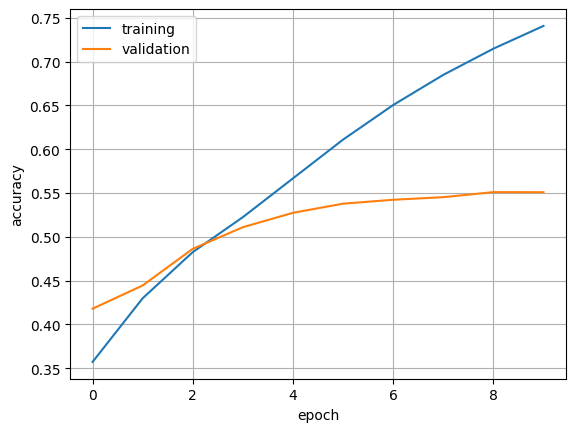

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

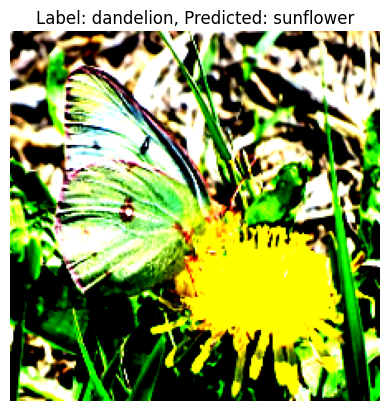

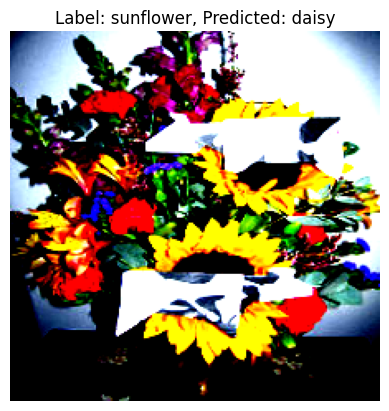

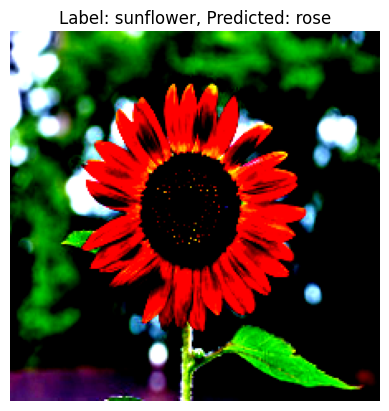

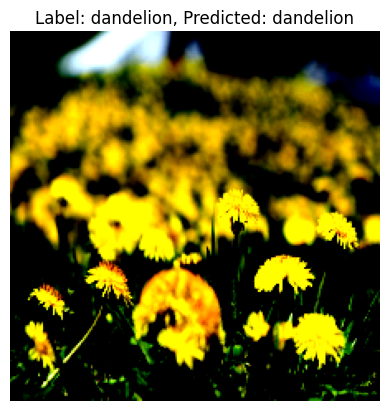

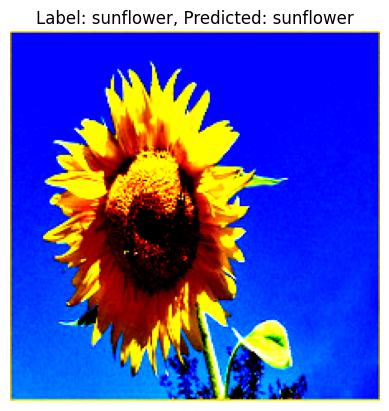

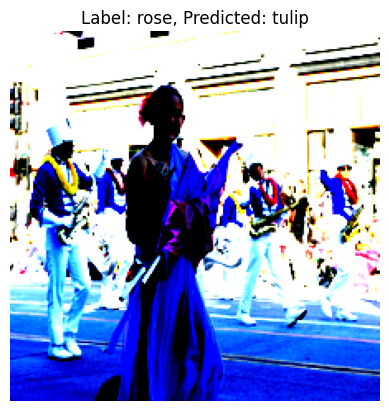

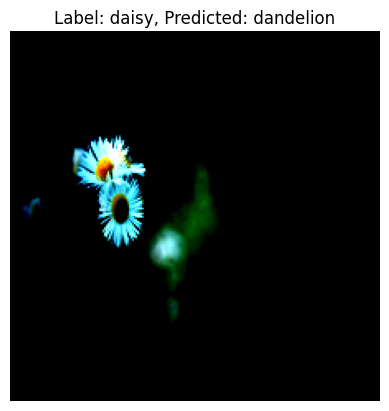

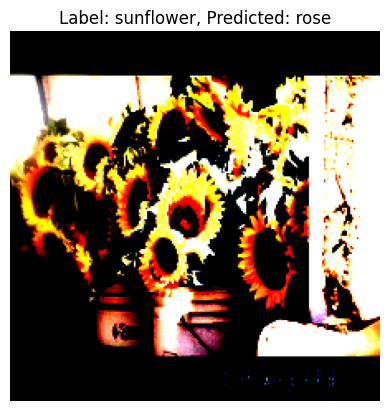

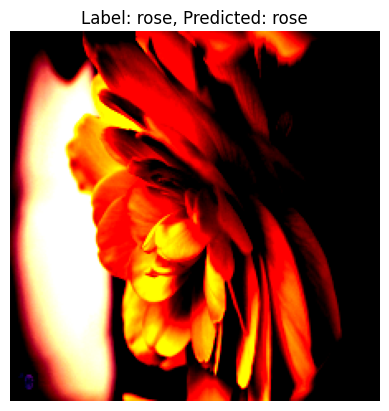

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание

В практическом задании я обучил еще одну сверточную архитектуру для задач классификации цветов.

In [17]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model1 = torchvision.models.alexnet(pretrained = True)
model1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):  
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model1)

In [19]:
model1.classifier[6] = torch.nn.Linear(4096, 5)
# меняем последний слой на 5 выходов, т.к. мы имеем 5 видов цветов

In [20]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(name)

classifier.6.weight
classifier.6.bias


In [21]:
model1.to(device) # Отправляем модель на GPU
optimizer = torch.optim.SGD(model1.parameters(), lr = 0.01) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model1, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track
# устанавливаем оптимизатор  с коэфициентом скорости обучения 0.001, 10 эпох и передаем модель в trainval

100%|██████████| 104/104 [00:20<00:00,  5.13it/s]


[training] Epoch: 0.00. Loss: 0.62. Accuracy: 77.63% 


100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


[validation] Epoch: 0.00. Loss: 0.43. Accuracy: 84.60% 


100%|██████████| 104/104 [00:19<00:00,  5.41it/s]


[training] Epoch: 1.00. Loss: 0.50. Accuracy: 81.79% 


100%|██████████| 32/32 [00:04<00:00,  6.47it/s]


[validation] Epoch: 1.00. Loss: 0.41. Accuracy: 85.55% 


100%|██████████| 104/104 [00:17<00:00,  5.92it/s]


[training] Epoch: 2.00. Loss: 0.44. Accuracy: 83.89% 


100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


[validation] Epoch: 2.00. Loss: 0.40. Accuracy: 85.97% 


100%|██████████| 104/104 [00:17<00:00,  5.87it/s]


[training] Epoch: 3.00. Loss: 0.40. Accuracy: 85.33% 


100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


[validation] Epoch: 3.00. Loss: 0.39. Accuracy: 86.45% 


100%|██████████| 104/104 [00:18<00:00,  5.65it/s]


[training] Epoch: 4.00. Loss: 0.37. Accuracy: 86.61% 


100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


[validation] Epoch: 4.00. Loss: 0.40. Accuracy: 86.20% 


100%|██████████| 104/104 [00:19<00:00,  5.31it/s]


[training] Epoch: 5.00. Loss: 0.35. Accuracy: 87.42% 


100%|██████████| 32/32 [00:05<00:00,  6.35it/s]


[validation] Epoch: 5.00. Loss: 0.40. Accuracy: 86.27% 


100%|██████████| 104/104 [00:18<00:00,  5.65it/s]


[training] Epoch: 6.00. Loss: 0.33. Accuracy: 88.22% 


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[validation] Epoch: 6.00. Loss: 0.40. Accuracy: 85.99% 


100%|██████████| 104/104 [00:18<00:00,  5.75it/s]


[training] Epoch: 7.00. Loss: 0.31. Accuracy: 88.78% 


100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


[validation] Epoch: 7.00. Loss: 0.40. Accuracy: 86.16% 


100%|██████████| 104/104 [00:17<00:00,  5.79it/s]


[training] Epoch: 8.00. Loss: 0.30. Accuracy: 89.27% 


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


[validation] Epoch: 8.00. Loss: 0.40. Accuracy: 86.27% 


100%|██████████| 104/104 [00:19<00:00,  5.34it/s]


[training] Epoch: 9.00. Loss: 0.29. Accuracy: 89.71% 


100%|██████████| 32/32 [00:04<00:00,  6.58it/s]

[validation] Epoch: 9.00. Loss: 0.40. Accuracy: 86.42% 


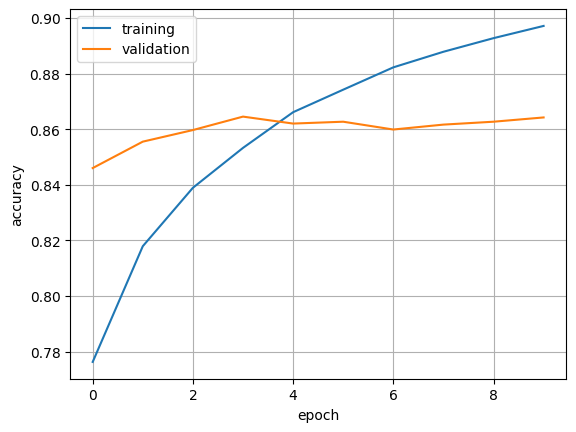

In [22]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

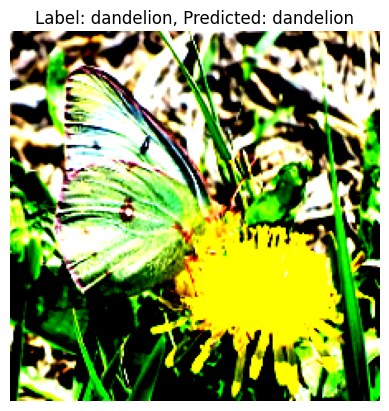

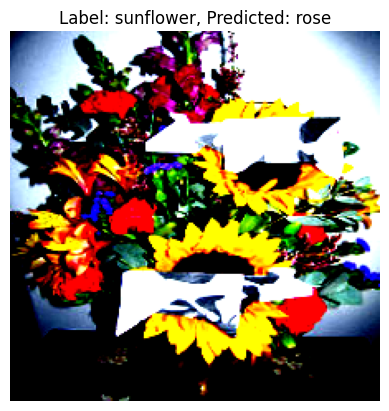

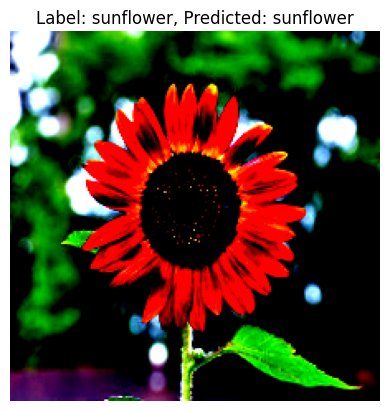

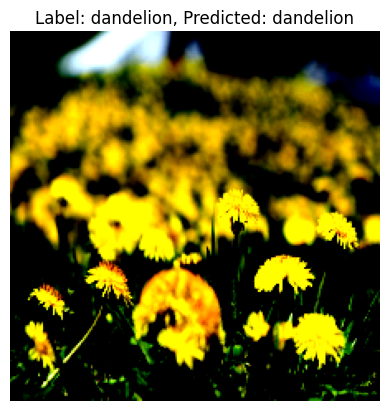

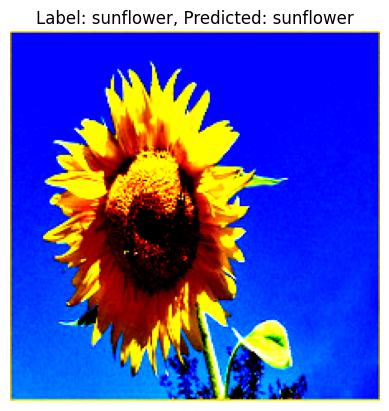

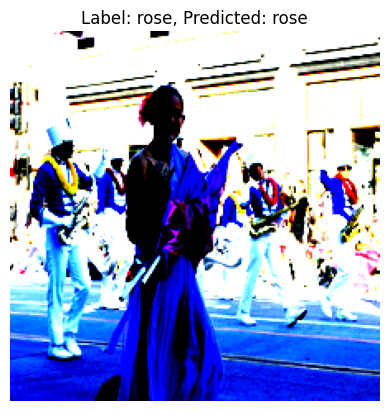

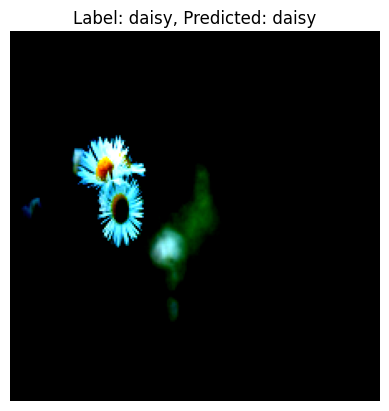

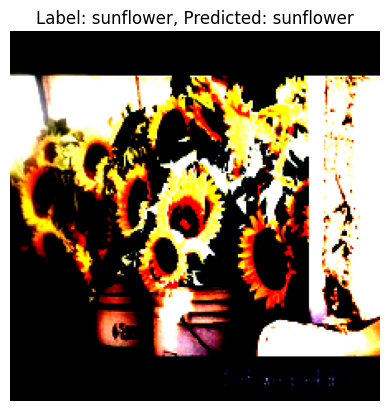

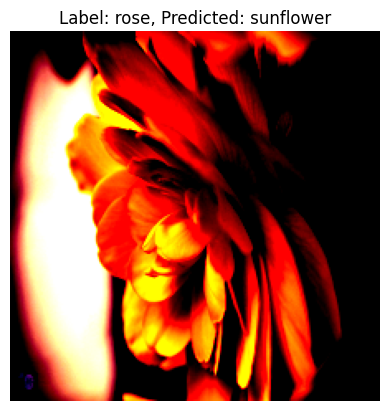

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model1)))
  plt.show()

По желанию, можно сохранить веса модели.

In [27]:
weights_fname = '/content/drive/MyDrive/data/***___**.pth'
torch.save(___.state_dict(), weights_fname) # Но у меня почему то кидает ошибку(

AttributeError: ignored